In [ ]:
%pip install --upgrade --quiet praw pypdf langchain-core langgraph langchain_openai

## LangGraph Research Assistant

We'll build a research assistant that combines 3 themes: 

1) `Report Generation` -- [Reports provide greater value than question-answering tools used in many RAG systems](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/). This is because reports offer more than just answers; they are tools for decision-making and resource allocation. Reports can save substantial costs by replacing the need for multiple employees or expensive processes.

2) `Automating multi-step workflows` -- There are some interesting examples of AI-mediated workflows that replace conventional investment dilligence. For example, [deal flow automation for VCs](https://x.com/MaxBrodeurUrbas/status/1806380947606253960) that analyzes pitch decks (e.g., extracts all metrics, finds founder LinkedIns + extracts their background, writes to Notion).

3) `Multi-perspective AI assistants` -- A generally powerful approach, as seen in papers like [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb), is to create AI assistants that take on various roles and have them simultanously inique about a topic.

### Approach

As an example, we'll apply these to the [llama3.1 paper](https://ai.meta.com/blog/meta-llama-3-1/).

And we'll lay out our assistant like this: 

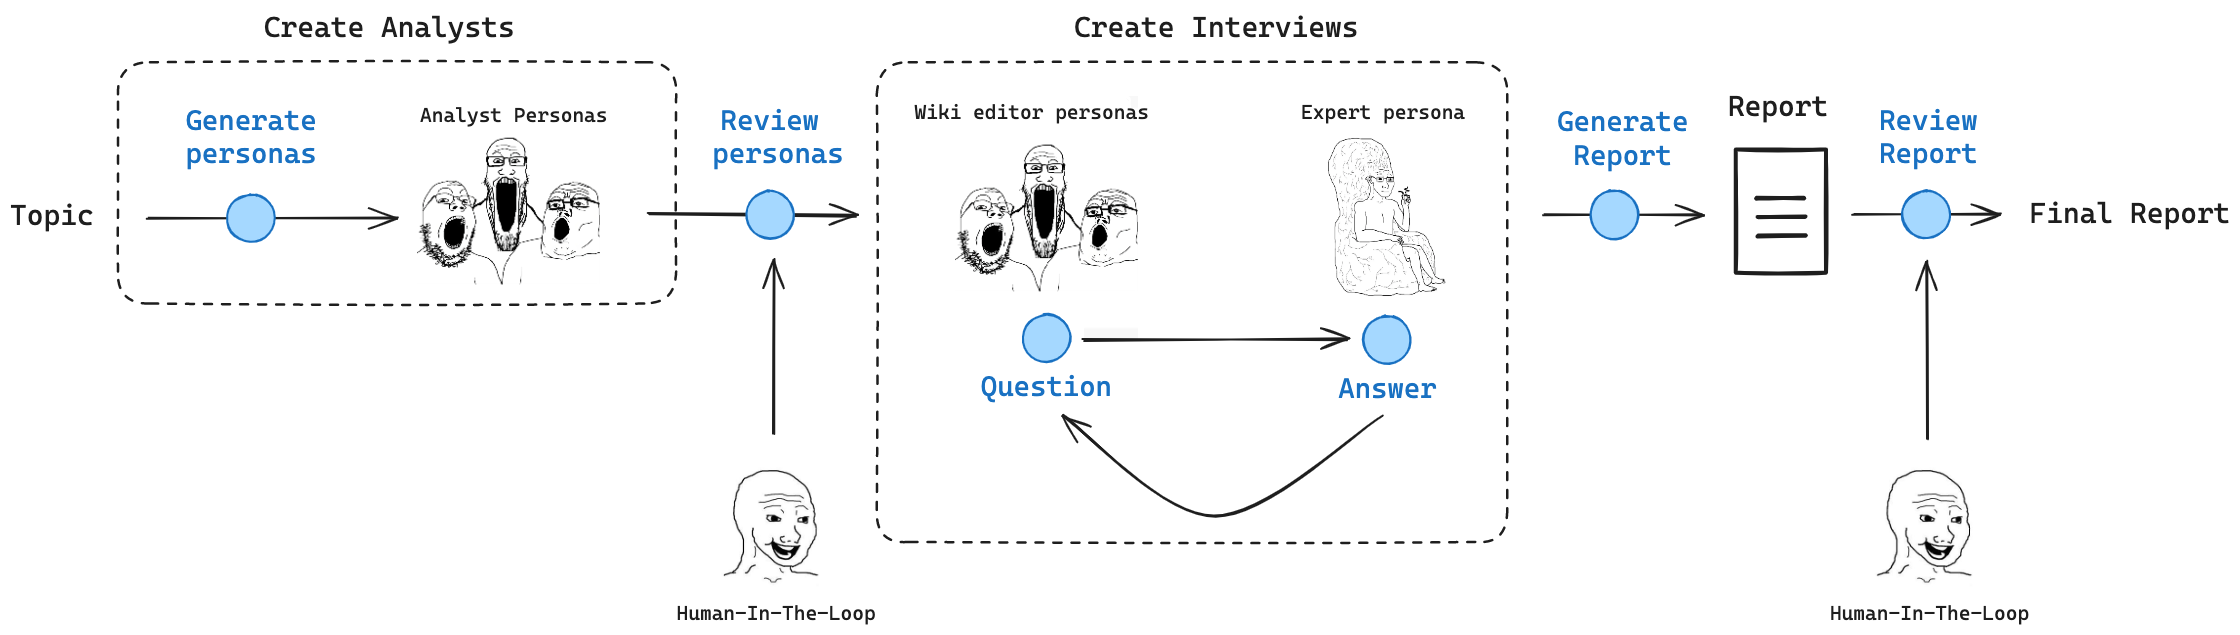

### Specify Topic and Content

First, select the topic of interest.

In [1]:
# Overall topic
topic = "Open source LLM investment themes based upon the Meta LLlama3.1 open source LLM"

#### Context for creating the analysts

Next, we want to create our analysts. 

Here, we have some options:

1. Prompt an LLM with a few specific themes

2. Let an LLM choose the specifics based upon some provided context

We choose option 2, using either comments from localLLaMA reddit posts or from Zuck's blog post.

The idea here is that we use context to select more specific and interesting focus ares for our analysts. 

In [ ]:
import praw

# URL of the Reddit post
url = 'https://www.reddit.com/r/LocalLLaMA/comments/1eabf4l/lets_discuss_llama31_paper_a_lot_of_details_on/'

# Replace the following values with your credentials
client_id = 'xxx'
client_secret = 'xxx'
user_agent = 'Local Llama Loader'

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

# Fetch the submission
submission = reddit.submission(url=url)

# Load the comments
submission.comments.replace_more(limit=None)
comments = submission.comments.list()

# Concatenate comments into a single string
ANALYST_TOPIC_GENERATION_CONTEXT = "\n *** user commnent *** \n".join([comment.body for comment in comments])

Or use Mark Zuckerberg letter about llama3.1

In [3]:
from langchain_community.document_loaders import WebBaseLoader
url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
ANALYST_TOPIC_GENERATION_CONTEXT = WebBaseLoader(url).load()

#### Context for your expert 

Next, we create our expert. 

Here we can use a few approaches:

1. RAG: Simply give the expert specific context (e.g., papers, source materials)

2. Search: Allow the expert to use web search.

Of course, we can also combine these.

Here, we simply use RAG as a starting point.
 
We can use the full llama3.1 paper (higher token usage). 

In [4]:
# Full llama3.1 paper
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("/Users/rlm/Desktop/llama3_1.pdf")
pages = loader.load_and_split()
EXPERT_CONTEXT = "\n *** *** *** \n".join([page.page_content for page in pages])

### Create Interviews

#### State

Here, we outline the states that we will use for our graph.

`InterviewState` is the "inner state", which will be used for each interview between expert and analyst.

`ResearchGraphState` is the "outer state", which will collate results from all interviews, write sections, and write the final report.

In [32]:
import operator
from typing import List, Optional
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the investment analyst.",
    )
    name: str = Field(
        description="Name of the investment analyst.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the investment analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the investment analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of investment analysts with their roles and affiliations.",
    )

class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    context: str = Field(..., title="Provide a clear summary of the focus area that you researched.")
    findings: str = Field(..., title="Give a clear and detailed overview of your findings based upon the expert interview.")
    thesis: str = Field(..., title="Give a clear and specific investment thesis based upon these findings.")

class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    analyst: Analyst
    interviews: list # This key is duplicated between "inner state" ...

class ResearchGraphState(TypedDict):
    analysts: List[Analyst]
    topic: str
    max_analysts: int
    interviews: Annotated[list, operator.add] # ... and "outer state"
    final_report: str
    editor_feedback: str 

#### LLM

In [6]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

#### Analysts

Create analysts based upon the `ANALYST_TOPIC_GENERATION_CONTEXT` as well as human feedback.

In [26]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """
            You are tasked with creating a set of AI investment analyst personas based on source documents. 

            The overall sope of the research is: {topic}
            
            These analysts will be responsible for researching different specific and narrow themes identified in the documents. 
            
            Your goal is to ensure:
            
            1. That the analysts capture interesting and diverse investment themes based on the provided information.

            2. Ensure that each analyst has a narrow and specific theme / question. Avoid making it too generic.

            First, carefully read and think about source documents:
            
            {documents}
            
            After analyzing the documents: 
            
            1. Use these documents to deign your set of AI investment analyst personas.
            
            2. Limit the number of analysts: Create no more than {max_analysts} different analyst personas.

            3. If the below messages specify any particular AI investment analyst personas to include, be sure to add them to your list.
            """,
            
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

@as_runnable
async def generate_analysts(state: ResearchGraphState):
    """ Node to generate analysts """

    # Get topic and max analysts from state
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    messages = state.get("messages", [])

    # Generate analysts
    gen_perspectives_chain = gen_perspectives_prompt | llm.with_structured_output(Perspectives)
    perspectives = gen_perspectives_chain.invoke({"documents": ANALYST_TOPIC_GENERATION_CONTEXT, 
                                                  "topic": topic, 
                                                  "messages": messages, 
                                                  "max_analysts": max_analysts})
    
    # Write the list of analysis to state
    return {"analysts": perspectives.analysts}

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

# Add human feedback / input 
messages = [HumanMessage(f"I am interested in the training strategy -- e.g., # of GPUs and network -- so please include this in your set of analysts.")]

# Test
initial_state = {"topic": topic, 
                 "messages": messages,
                 "max_analysts": 6}

perspectives = await generate_analysts.ainvoke(initial_state)

In [10]:
perspectives

{'analysts': [Analyst(affiliation='Meta', name='Alice Thompson', role='Open Source Ecosystem Analyst', description='Alice focuses on the development and growth of the open source ecosystem around Llama models. She analyzes partnerships, community contributions, and the overall impact of open source on AI development.'),
  Analyst(affiliation='Meta', name='John Davis', role='AI Model Efficiency Analyst', description='John specializes in evaluating the cost and performance efficiency of AI models. He compares Llama models with closed models like GPT-4o, focusing on metrics such as inference cost, latency, and hardware requirements.'),
  Analyst(affiliation='Meta', name='Sarah Lee', role='AI Safety and Security Analyst', description='Sarah is responsible for assessing the safety and security aspects of open source AI models. She examines the potential for unintentional and intentional harm, and evaluates the effectiveness of safety systems like Llama Guard.'),
  Analyst(affiliation='Meta'

### Ask Question

Prompt analyst to ask questions to the expert.

In [11]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an experienced investment analyst tasked with interviewing an expert to perform due diligence on a specific topic. 
            
            Your goal is to use this information to build an investment thesis given this topic and set of goals: {persona}
            
            Begin by introducing yourself using a name that fits your persona. 
            
            Stay true to your specific perspective throughout the conversation. 
            
            When interviewing the expert, follow this strategy:
            1. Start with broad, open-ended questions to clarify your understanding of the topic.
            2. As you gain more information, narrow your questions to drill deeper into specific aspects that are relevant to your investment thesis.
            3. Pay close attention to the expert's responses and look for opportunities to explore promising angles or address potential concerns.

            Here's how to analyze the expert's responses as the conversation proceeds:
            1. Carefully read and consider the information provided by the expert.
            2. Identify key points, trends, or insights that could be relevant to your investment thesis.
            3. Note any areas where you need more clarification or additional information.

            Based on your analysis, formulate follow-up questions that will help you gather more specific and relevant information. Your questions should:
            - Address any gaps in your understanding
            - Explore potential risks or opportunities
            - Seek quantitative data or specific examples to support claims
            - Probe into the expert's confidence level and the basis for their opinions

            Remember, your ultimate goal is to build an investment thesis on your topic. 

            When you are satisfied, complete the interview with: "Thank you so much for your help!"

            Remember to stay in character throughout your response, reflecting the persona and research goals provided to you.
            
            """,
        
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

@as_runnable
async def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    gen_question_chain = gen_qn_prompt.partial(persona=analyst.persona) | llm   
    result = gen_question_chain.invoke({"messages": messages})
    
    # Write messages to state
    return {"messages": [result]}

In [ ]:
# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
i = 3 # analyst to test 
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}
question = await generate_question.ainvoke(interview_state)
messages.extend(question['messages'])

### Create Expert

Prompt expert to answer question using `EXPERT_CONTEXT`.

In [15]:
# Expert RAG prompt 
gen_expert_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert on the topic of {{topic}}.
            
            You are being interviewed by an investment analyst who is building an investment thesis about this topic. 
            
            Your goal is to provide clear, concise, and insightful answers to their questions using the information provided in the context.

            Here is the context you should use to inform your answers:
            {context}

            When answering questions, follow these guidelines:
            
            1. Use only the information provided in the context above. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
            
            2. Structure your answers to first provide a clear description of technical concepts.

            3. Then, think carefully about the technical concepts presented and explain how they can help the analyst build an investment thesis.
                        
            4. If a question cannot be answered based on the given context, state that you don't have enough information to provide a complete answer.
            
            Remember that your goal is to help the interviewer build towards an investment thesis.""",
            
        ),
        
            MessagesPlaceholder(variable_name="messages", optional=True),
        ]
)

@as_runnable
async def generate_answer(state: InterviewState):
    """ Node to answer a question """

    # Get state
    messages = state["messages"]
    
    # Answer question
    answer_chain = gen_expert_prompt | llm
    answer = answer_chain.invoke({'messages': messages,
                                  'topic': topic,
                                  'context': EXPERT_CONTEXT})  
    
    # Name the message as coming from the expert
    # We use this later to count the number of times the expert has answered
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [ ]:
# Test
interview_state = {"analyst": perspectives["analysts"][i], 
                   "messages": messages}

answer = await generate_answer.ainvoke(interview_state)
messages.extend(answer['messages'])

### Interview between expert and analyst

Combine the above into an interview graph.

Use `max_num_turns` to set the number of times you want the expert to answer.

If the expert is using a large context, as in the case here with llama3.1 paper, we can restrict this to only a single turn.

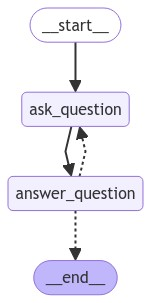

In [36]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Max turns
max_num_turns = 1

# Conditional edge
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return END

    # This router is perform after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help!" in last_question.content:
        return END
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages)

# Set up memory
memory = MemorySaver()

# Interview 
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [38]:
# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
i = 3 # analyst to test 
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run
interview = await interview_graph.ainvoke(interview_state, thread)

We can get the state for the full interview.

In [39]:
full_interview_state = interview_graph.get_state(thread).values["messages"]

And we can look at specific messages.

In [40]:
full_interview_state[-1].content[0:250]

"Certainly, I'd be happy to provide an overview based on the context provided.\n\n### Training Strategies for Llama Models\n\n#### General Approach\nMeta's Llama models, including the Llama 3.1 series, are developed with a focus on optimizing data quality,"

### Report writing

Write a report based upon the interviews.

In [41]:
from langchain_core.messages import get_buffer_string

section_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are writing a report on topic: {topic}

            Your team of analysts conducted several interviews with an expert on this topic.

            Here is your task:
            
            1. Analyze the interview content thoroughly.
            
            2. Write a comprehensive report based on the interviews. 
            
            3. Use proper markdown formatting throughout your document. 

            4.  Use headers (##, ###, etc.) to separate sections, bullet points or numbered lists where appropriate, and emphasis (bold or italic) for key points.

            5. The document introduction outlines the topic and gives some overall context.

            6. Each interview has its own section in the document.

            7. In each section, provide:

               a. Overview of the interview
               b. Key Insights from the interview
               c. Whether there are any investable themes

            8. If there is any user / editor feedback, be sure to incorperate those points into your report.
            
            Here are the interviews: : {interviews}
            
            Here is any user / editor feedback: {editor_feedback} """,
        
        ),
    ]
)

@as_runnable
def generate_report(state: ResearchGraphState):
    """ Node to generate final report """

    # State 
    interviews = state["interviews"]
    editor_feedback = state.get("editor_feedback", [])

    # Full set of interviews
    formatted_str_interview = "\n\n".join([f"Interview # {i}\n{interview}" for i, interview in enumerate(interviews, start=1)])

    # Generate report
    section_gen_chain = section_gen_prompt | llm
    report = section_gen_chain.invoke({"interviews": formatted_str_interview, 
                                       "topic": topic,
                                       "editor_feedback": editor_feedback})
    
    return {"final_report": report}

In [ ]:
# Add in some editor feedback
editor_feedback = "In the section about training, be sure to include a mention on infiniband and how / whether it was used."

# Convert the messages in the interview into a string
initial_state= {"interviews": [get_buffer_string(interview['messages'])],
                "editor_feedback": editor_feedback,
                "topic": topic}

final_report = generate_report.invoke(initial_state)

## Full Analyst

Now, we combine and parallelize these steps:

* `interview_builder` is a sub-graph that conducts the interview
* We write the interview to our "inner state" (`InterviewState`) key, `interviews`
* Key point: this is propogated our to the "outer state" key, `interviews`
* Our "outer state" key has a reducer that appends the results from each interview to the key, `interviews`

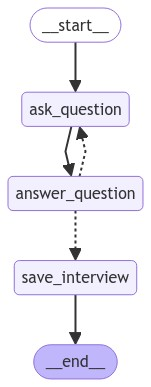

In [43]:
def save_interview(state: InterviewState):
    """ Save interviews to interviews"""

    # Get messages
    messages = state["messages"]
    # Convert interview to a string
    interview = get_buffer_string(messages)
    # Save to interviews
    return {"interviews": [interview]}

# Conditional edge
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router is perform after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help!" in last_question.content:
        return "save_interview"
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,["ask_question","save_interview"])
interview_builder.add_edge("save_interview", END)

sub_graph = interview_builder.compile(checkpointer=memory)
display(Image(sub_graph.get_graph(xray=1).draw_mermaid_png()))

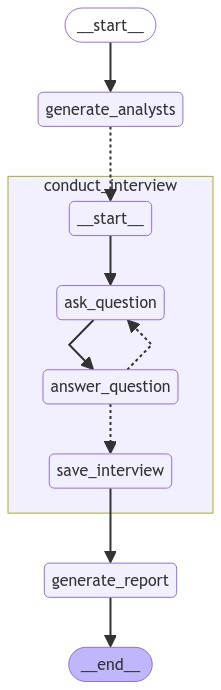

In [44]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ Edge to run the interview sub-graph using Send """    
    return [Send("conduct_interview", {"analyst": analyst,
                                       "messages": [HumanMessage(
                                           content=f"So you said you were writing an article on {topic}?"
                                       )
                                                   ]}) for analyst in state["analysts"]]
    
builder = StateGraph(ResearchGraphState)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("generate_report", generate_report)

builder.add_edge(START, "generate_analysts")
builder.add_conditional_edges("generate_analysts", initiate_all_interviews, ["conduct_interview"])
builder.add_edge("conduct_interview", "generate_report")
builder.add_edge("generate_report", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [46]:
# Thread
thread = {"configurable": {"thread_id": "1"}}


# Add human feedback / input 
messages = [HumanMessage(f"I am interested in the training strategy -- e.g., # of GPUs and network -- so please include this in your set of analysts.")]

# Test
initial_state = {"topic": topic, 
                 "messages": messages,
                 "max_analysts": 3}

# Run
research_results = await graph.ainvoke(initial_state, thread)

In [47]:
from IPython.display import Markdown
Markdown(research_results['final_report'].content.replace("\n#", "\n##"))

# Investment Themes in Open Source LLMs Based on Meta's Llama 3.1

### Introduction

The landscape of artificial intelligence (AI) is rapidly evolving, with open-source large language models (LLMs) playing a pivotal role in driving innovation and accessibility. Meta's Llama 3.1 series stands out as a significant development in this space, offering high-performance models that are open-source and designed to spur advancements in AI. This report delves into the investment themes surrounding the Llama 3.1 models, based on insights from expert interviews. We will explore the current state of the open-source AI ecosystem, cost efficiency and performance, and safety and security aspects, providing a comprehensive overview of potential investment opportunities.

### Interview #1: Overview of the Open Source AI Ecosystem

#### Overview of the Interview

In this interview, Evelyn provided a detailed overview of the open-source AI ecosystem surrounding Meta's Llama 3.1 models. The discussion covered key players, partnerships, collaborations, and driving factors that are shaping this ecosystem.

#### Key Insights

- **Key Players**:
  - **Meta**: Developer of the Llama models, leading the ecosystem with the release of Llama 3.1.
  - **Research Community**: Actively leveraging Llama models for innovation and exploration.
  - **Developers and Startups**: Integrating Llama models into various products and services.

- **Partnerships and Collaborations**:
  - **Academic Institutions**: Collaborations for joint research and development.
  - **Industry Collaborations**: Partnerships with tech companies for tool integration and dataset sharing.
  - **Open-Source Community**: Contributions to code enhancements, bug fixes, and complementary tools.

- **Driving Factors**:
  - **Data and Scale**: Significant improvements in data quality and scale, with the largest model pre-trained on 15.6 trillion text tokens.
  - **Managing Complexity**: Design choices for scalability and stability, using a dense Transformer model architecture.
  - **Safety and Responsibility**: Extensive safety measures, including Llama Guard 3 for input and output safety.

#### Investable Themes

1. **Innovation and Leadership**: Meta's leadership in developing high-quality, open-source AI models positions them as a key player. Investing in companies leveraging Llama models could yield significant returns.
2. **Ecosystem Growth**: The collaborative nature of the Llama models fosters a diverse and innovative ecosystem. Companies contributing to or benefiting from this ecosystem are likely to experience growth.
3. **Scalability and Adaptability**: The models' scalability and adaptability make them suitable for various applications, presenting opportunities in diverse market segments.
4. **Safety and Ethics**: Companies prioritizing ethical AI practices and leveraging safe AI models like Llama 3.1 are likely to gain a competitive edge.

### Interview #2: Cost Efficiency and Performance

#### Overview of the Interview

David provided insights into the cost efficiency and performance of the Llama 3.1 series compared to other open-source and closed-source AI models. The discussion highlighted the technical aspects, training efficiency, and market potential of these models.

#### Key Insights

- **Technical Concepts**:
  - **Model Architecture and Scale**: Llama 3.1 models include 8B, 70B, and 405B parameters, using a dense Transformer architecture.
  - **Training Data and Scale**: Trained on a massive corpus of about 15T multilingual tokens, with significant computational resources.
  - **Performance**: Competitive with leading models like GPT-4, evaluated on benchmarks spanning various tasks.
  - **Open Source and Accessibility**: Public release intended to spur innovation and accelerate AGI development.

- **Cost Efficiency**:
  - **Training Efficiency**: Optimized training process balancing data quality, scale, and complexity management.
  - **Inference Efficiency**: Compute-optimal design delivering high performance without unnecessary overhead.
  - **Open Source Advantage**: Reduces barriers to entry, driving broader adoption and innovation.

- **Performance**:
  - **Competitive Edge**: Comparable performance to leading closed-source models, with advantages in handling long context windows.
  - **Versatility**: Supports multilinguality, coding, reasoning, and tool usage, with potential for multimodal tasks.

- **Market Potential**:
  - **Broad Adoption**: Open-source nature drives widespread adoption across industries.
  - **Innovation Catalyst**: High-quality foundation model catalyzing innovation in the AI research community.

#### Investable Themes

1. **Cost Efficiency**: The optimized training and inference processes make Llama 3.1 models cost-effective, presenting opportunities for investment in companies leveraging these models.
2. **Performance**: Competitive performance and versatility make these models attractive for various applications, offering investment potential in diverse sectors.
3. **Market Potential**: Broad adoption and innovation catalyzed by the open-source nature of Llama 3.1 create significant market opportunities.

### Interview #3: Safety and Security

#### Overview of the Interview

Sophia provided an in-depth analysis of the safety and security concerns associated with open-source AI models like Llama 3.1. The discussion covered data contamination, safety finetuning, system-level safety, and residual risk assessment.

#### Key Insights

- **Technical Concepts**:
  - **Data Contamination and Memorization**: Rigorous data curation and techniques to reduce memorization of sensitive information.
  - **Safety Finetuning**: Supervised finetuning and direct preference optimization to ensure safe and helpful responses.
  - **System-Level Safety**: Llama Guard 3 for detecting and filtering unsafe content.
  - **Red Teaming and Residual Risk Assessment**: Adversarial testing and risk evaluation to enhance model safety.

- **Building an Investment Thesis**:
  - **Market Differentiation**: Safety measures as a competitive advantage in markets with high data privacy and security requirements.
  - **Regulatory Compliance**: Alignment with data protection regulations like GDPR and CCPA.
  - **Adoption in Sensitive Industries**: Trust and reliability driving adoption in sectors handling sensitive information.
  - **Open Source Community and Innovation**: Community contributions enhancing safety and capabilities.
  - **Cost Efficiency**: Reduced liability costs due to strong safety measures.

#### Investable Themes

1. **Market Differentiation**: The rigorous safety measures position Llama 3.1 as a safer alternative, presenting investment opportunities in markets with stringent data privacy and security requirements.
2. **Regulatory Compliance**: Alignment with data protection regulations makes Llama 3.1 attractive to enterprises needing to adhere to strict data governance policies.
3. **Adoption in Sensitive Industries**: Extensive safety finetuning and system-level safeguards drive adoption in sectors like healthcare, finance, and legal services.
4. **Open Source Community and Innovation**: Community-driven innovation enhances the model's robustness, presenting opportunities for investment in specialized safety features.
5. **Cost Efficiency**: Strong safety measures reduce liability costs, making Llama 3.1 a cost-effective choice for businesses.

### Conclusion

The open-source AI ecosystem surrounding Meta's Llama 3.1 models presents compelling investment opportunities across various themes. From innovation and leadership to cost efficiency, performance, and safety, the Llama 3.1 series stands out as a significant development in the AI space. Companies leveraging these models, contributing to the ecosystem, or prioritizing ethical AI practices are well-positioned to benefit from the growth and advancements driven by Llama 3.1.

LangSmith trace:

https://smith.langchain.com/public/beb6da7d-f438-4d4a-9eec-977d55cd5d0c/r